In [1]:
# --- my modules
from sample_selection import sample_selection
from proposed_algorithm import domain_invariant_unsupervised_sample_selection as diuss 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mtply
import pandas as pd
import scipy as sp
import scipy.io as sp_io
from scipy.spatial.distance import cdist

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

## Pharmaceutical Tables

In [3]:
data_url = "https://gitlab.com/vfonsecad/chemometrics_data/-/raw/main/data/nir_pharmaceutical_tablets/nir_shootout_2002_all.csv"
data_pd_raw = pd.read_csv(data_url, sep = ";", index_col = 0)

df = data_pd_raw[(data_pd_raw["instrument"] == "instrument_1") & (data_pd_raw["type"] == "calibration")]
df_initial = np.array(df.iloc[:,5:]) 
samples_initial_id =  df["sample_id"]
print(df.shape)
print(df_initial.shape)

(155, 656)
(155, 651)


In [4]:
x_initial = df_initial[:,1:] 
# Y =Assay
y_initial = df_initial[:,5]
print(x_initial.shape)
print(y_initial.shape)

(155, 650)
(155,)


### <span style="color:#00BDFF">Setting calibration and test datasets</span>

In [5]:
n_cal = 100

rng = np.random.RandomState(7620987)
cal_samples = rng.choice(x_initial.shape[0], n_cal, replace = False)
nocal_samples = np.asarray([ii for ii in range(x_initial.shape[0]) if ii not in cal_samples])

x_all = np.array(x_initial)[cal_samples,0:]
y_all = np.array(y_initial)[cal_samples]

x_test = np.array(x_initial)[nocal_samples,0:]
y_test = np.array(y_initial)[nocal_samples]

y_all.shape = (y_all.shape[0],1)
y_test.shape = (y_test.shape[0],1)
print(x_all.shape)
print(y_all.shape)
print(x_test.shape)
print(y_test.shape)

(100, 650)
(100, 1)
(55, 650)
(55, 1)


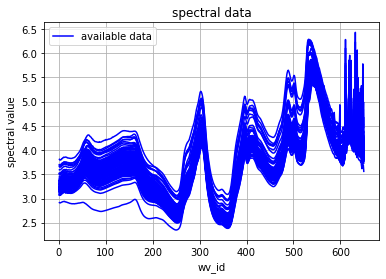

In [6]:
# visualize data
wv_range = np.arange(1,x_all.shape[1]+1) 
plt.plot(wv_range,x_all[0], c = "blue", label = "available data") #(Row 1)
plt.plot(wv_range,x_all.T, c = "blue") #.T is the transpose matrix (Column 1)
plt.xlabel("wv_id")
plt.ylabel("spectral value")
plt.title("spectral data")
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Dataset for R
#data = pd.DataFrame(data_initial)
#data.to_excel('pig_data.xlsx', sheet_name='sheet1', index=False)

### <span style="color:#00BDFF">Setting calibration and test datasets</span>

In [7]:
n_cal = 100

rng = np.random.RandomState(7620987)
cal_samples = rng.choice(x_initial.shape[0], n_cal, replace = False)
nocal_samples = np.asarray([ii for ii in range(x_initial.shape[0]) if ii not in cal_samples])

x_all = np.array(x_initial)[cal_samples,0:]
y_all = np.array(y_initial)[cal_samples]

x_test = np.array(x_initial)[nocal_samples,0:]
y_test = np.array(y_initial)[nocal_samples]

y_all.shape = (y_all.shape[0],1)
y_test.shape = (y_test.shape[0],1)
print(x_all.shape)
print(y_all.shape)
print(x_test.shape)
print(y_test.shape)

(100, 650)
(100, 1)
(55, 650)
(55, 1)


In [8]:
# initial pca for exploratory analysis 
pca_mu = x_all.mean(axis=0)  # mean(axis=0) is an array with the mean per column

X_c = x_all - pca_mu #Mean centering X_initial
X_c_t = np.ascontiguousarray(X_c.transpose()) 
cov_X = X_c_t.dot(X_c)/(X_c.shape[0]-1) # ([X_c^T]*[[X_c]) / n ; 
svd_cov_X = np.linalg.svd(cov_X) # Singular Value Decomposition

chosen_pc = 20 #sugested number 

pc_loadings = svd_cov_X[0][:,0:chosen_pc] # first 25 coulums from left eigenvectors U
tscores = (x_all - pca_mu).dot(pc_loadings) #X centered * Loadings
x_all_predicted = tscores.dot(pc_loadings.T) + pca_mu

q_residuals = np.mean(np.power(x_all - x_all_predicted,2),axis=1) # Mean per row of (Xi -Xp)^2
hotelling_t2 = np.diag(tscores.dot(np.diag(1/svd_cov_X[1][0:chosen_pc])).dot(tscores.T)) 
#Dig( tscores(155,10)* Dia(1/SVD_Cov_X(650,1))*tscores^T)

print("proportion of variance first pc's: ",np.round(svd_cov_X[1]/np.sum(svd_cov_X[1]),6)[0:chosen_pc])
# Eigenvalue(i)/Sum(Eigenvalues)
# Eigenvalues = expalined variance

print(x_all)
x_all.shape

proportion of variance first pc's:  [7.67491e-01 1.62729e-01 1.69510e-02 9.81100e-03 7.48000e-03 4.73000e-03
 4.17100e-03 2.64900e-03 2.46800e-03 1.84900e-03 1.71300e-03 1.59500e-03
 1.48000e-03 1.19100e-03 1.12400e-03 1.09400e-03 1.03500e-03 8.83000e-04
 7.64000e-04 7.45000e-04]
[[3.222189 3.218993 3.222457 ... 3.811269 4.148804 3.869917]
 [3.362494 3.359415 3.365298 ... 3.965133 3.934787 4.107636]
 [3.336422 3.335102 3.336192 ... 3.808294 3.945966 3.875124]
 ...
 [3.255553 3.249846 3.25382  ... 4.14115  4.217447 4.29589 ]
 [3.17229  3.176289 3.17695  ... 3.784885 3.874649 3.892509]
 [3.081844 3.082077 3.084576 ... 3.852874 3.978674 3.96045 ]]


(100, 650)

In [12]:
#pd.DataFrame(pc_loadings)

In [13]:
#pd.DataFrame(tscores)

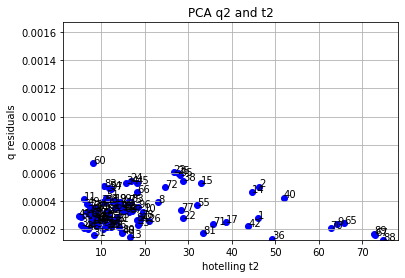

In [9]:
plt.scatter(hotelling_t2,q_residuals,c="blue")
for ii in range(hotelling_t2.shape[0]):
    plt.text(hotelling_t2[ii],q_residuals[ii], str(ii))
plt.grid()
plt.ylim(np.amin(q_residuals),np.amax(q_residuals)+0.001)
plt.xlabel("hotelling t2")
plt.ylabel("q residuals")
plt.title("PCA q2 and t2")
plt.show()
# No samples are going to be removed

In [ ]:
# --- observations to carry for unsupervised sample selection if necessary
#samples_initial_id = np.arange(0,len(x_all))
#drop_obs = [ ] 
#keep_obs = [ii for ii in range(x_all.shape[0]) if ii not in drop_obs]

#x_all_keep = np.delete(x_all, obj = drop_obs, axis=0)
#samples_all_id = samples_initial_id[keep_obs]

#y_all_keep = np.delete(y_all, obj = drop_obs, axis=0)

#print(x_all_keep.shape)
#print(y_all_keep.shape)

In [32]:
#Exporting calibration data to use in R
CAL_X= pd.DataFrame(x_all)
CAL_X.to_excel('3x_all_pharma.xlsx', sheet_name='sheet1', index=False)
CAL_X

,0,1,2,3,4,5,6,7,8,9,...,640,641,642,643,644,645,646,647,648,649
0,3.222189,3.218993,3.222457,3.232952,3.242569,3.256378,3.263915,3.274403,3.278520,3.284138,...,4.078949,4.000156,4.113154,4.060876,4.046516,4.095449,4.035752,3.811269,4.148804,3.869917
1,3.362494,3.359415,3.365298,3.369313,3.380896,3.390057,3.397392,3.408020,3.412745,3.421372,...,3.943309,4.182379,4.152322,4.197466,4.127862,3.983226,4.135071,3.965133,3.934787,4.107636
2,3.336422,3.335102,3.336192,3.342918,3.355735,3.367185,3.378420,3.388812,3.395505,3.398501,...,3.937562,4.092691,4.058649,3.944083,3.927386,5.219378,4.184143,3.808294,3.945966,3.875124
3,3.198291,3.197471,3.203439,3.209754,3.218118,3.229152,3.237245,3.247514,3.257829,3.264858,...,4.096292,4.456160,4.137371,4.060915,3.847914,3.995423,4.074332,3.823175,3.896240,3.910210
4,3.375981,3.376270,3.378307,3.384900,3.394129,3.403675,3.412664,3.420600,3.428792,3.434661,...,3.977312,4.384303,4.128240,3.974416,4.048313,4.117107,3.981493,4.240394,4.177460,4.072061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.515958,3.508764,3.506552,3.515303,3.523444,3.540164,3.542730,3.550499,3.557072,3.567687,...,4.514601,4.295384,4.327776,4.401777,4.221279,4.386615,4.163461,4.095882,3.859326,4.385302
96,3.274547,3.270422,3.271505,3.278761,3.293192,3.302314,3.315766,3.323994,3.328422,3.333645,...,4.135412,4.182991,4.272410,4.373246,4.358578,4.045496,4.002571,4.141998,4.209366,3.940407
97,3.255553,3.249846,3.253820,3.262403,3.269518,3.278559,3.288674,3.297159,3.302346,3.312045,...,4.122804,4.422803,4.276368,4.374510,4.239634,4.104357,4.211357,4.141150,4.217447,4.295890
98,3.172290,3.176289,3.176950,3.183415,3.191309,3.197637,3.206699,3.214117,3.219978,3.219948,...,3.949766,3.923321,3.861838,4.060498,4.001212,3.825434,3.971662,3.784885,3.874649,3.892509


# <span style="color:#00BDFF">unsupervised sample selection</span>

In [10]:
# --- determine optimal complexity
d = 4 # number of lv
n_sel = 12*d+1
a = 20 # number of pc 
print("n: ", n_sel)
print("a: ", a)

n:  49
a:  20


In [11]:
my_sample_selection = sample_selection(x_all, ncp = a)  
my_sample_selection

## Z matrix for Diuss Method

In [12]:
sub_samples = diuss.sub_matrix(x_matrix = x_all, num_samples=n_sel)
Z=sub_samples[0]
X_minus_Z=sub_samples[1]
Z_samples=sub_samples[2]
X_minus_Z_samples=sub_samples[3]

Z= element [0] dimetion: (49, 650) numpy.ndarray
Y= element [1] dimetion: (51, 650) numpy.ndarray
Zsamples= element [2] length: 49 numpy.ndarray
Ysamples= element [3] length: 51 numpy.ndarray


## State of the art Methods

In [13]:
# The DOE selection method was performed in R using PCA and optFederov functions
DOE = [ 1, 2, 3, 4, 6, 7, 8, 9, 10, 13, 14, 15, 17, 22, 23, 24, 25, 
26, 32, 33, 34, 36, 38, 40, 42, 43, 45, 53, 55, 61, 62, 65, 66, 
67, 68, 70, 71, 72, 75, 77, 78, 80, 81, 84, 88, 89, 91, 95, 96]


DOE = np.array(DOE)
DOE.shape

(49,)

In [14]:
Z_DOE= np.zeros(len(x_all),dtype=int)

for i in range(len(Z_DOE)):  
    if i in DOE:
        Z_DOE[i] = 1
Z_DOE

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0])

In [15]:
# --- select samples
my_sample_selection = sample_selection(x_all, ncp = a)  
my_sample_selection.get_xcal_pca_scores()

selected_sets = {}

selected_sets["ks_sample"] = my_sample_selection.kennard_stone(Nout=n_sel, fixed_samples=None, use_pca_scores=True,distance_metric='mahalanobis')
selected_sets["duplex_sample"] = my_sample_selection.duplex(Nout = n_sel, use_pca_scores=True, distance_metric='mahalanobis')
selected_sets["puch_sample"] = my_sample_selection.puchwein(Nout = n_sel, factor_k=0.0001, use_pca_scores=True, distance_metric='mahalanobis')
selected_sets["clus_sample"] = my_sample_selection.clustering(Nout = n_sel , use_pca_scores=True, distance_metric='euclidean', linkage = "complete")
selected_sets["all_samples"] = np.full(len(x_all), 1, dtype=int)
selected_sets["DOE"] = Z_DOE

## Diuss Method

In [16]:
#Diuss using max sigmas from SVD
best_max=diuss.diuss_max(X = x_all, Z = Z, Y = X_minus_Z, Z_samples = Z_samples,
                         Y_samples = X_minus_Z_samples, iterations=4000)
#Diuss using sum of sigmas from SVD
best_sum=diuss.diuss_sum(X = x_all, Z = Z, Y = X_minus_Z, Z_samples = Z_samples,
                         Y_samples = X_minus_Z_samples, iterations=4000)

In [18]:
selected_sets["diuss_max"] = best_max[5]
selected_sets["diuss_sum"] = best_sum[5]

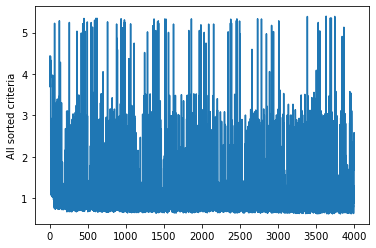

In [19]:
#The criterion shows convergence diuss_max
diuss.crit_behavior(all_crit = best_max[4])

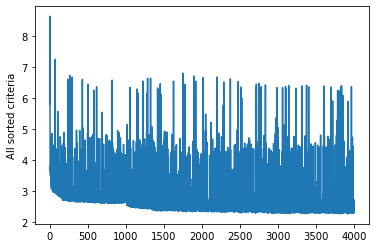

In [20]:
#The criterion shows convergence diuss_sum
diuss.crit_behavior(all_crit = best_sum[4])

In [21]:
print("KS: ",selected_sets["ks_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["ks_sample"]))
print("Duplex: ",selected_sets["duplex_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["duplex_sample"]))
print("puch_sample: ",selected_sets["puch_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["puch_sample"]))
print("clus_sample: ", selected_sets["clus_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["clus_sample"]))
print("diuss_max:",selected_sets["diuss_max"],"total_samples:",diuss.count_of_ones(array = selected_sets["diuss_max"]))
print("diuss_sum:",selected_sets["diuss_sum"],"total_samples:",diuss.count_of_ones(array = selected_sets["diuss_sum"]))
print("DOE:",selected_sets["DOE"],"total_samples:",diuss.count_of_ones(array = selected_sets["DOE"]))
print("all_samples:",selected_sets["all_samples"],"total_samples:",diuss.count_of_ones(array = selected_sets["all_samples"]))

KS:  [0 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 0 1
 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0
 0 0 0 1 1 0 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0] total_samples: 49
Duplex:  [0 1 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1
 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 1 0
 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 1] total_samples: 49
puch_sample:  [0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1
 0 1 0 1 0 1 1 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 0
 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 0] total_samples: 49
clus_sample:  [0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 1
 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 0 0 0
 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 1 1 1 1] total_samples: 49
diuss_max: [0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 

In [22]:
def sample_list(method_samples):
    l = len(method_samples)
    r=np.zeros((), dtype=int)

    for i in range(l):
        if method_samples[i] == 1:
            r=np.append(r,i)
    r=r[1:] # To eleiminate the first 0 from np.Zeros
    return(r)

In [25]:
Ks = sample_list(method_samples=selected_sets["ks_sample"])
dup = sample_list(method_samples=selected_sets["duplex_sample"])
puch = sample_list(method_samples=selected_sets["puch_sample"])
clus = sample_list(method_samples=selected_sets["clus_sample"])
d_max = sample_list(method_samples=selected_sets["diuss_max"])
d_sum = sample_list(method_samples=selected_sets["diuss_sum"])


In [26]:
# Samples ID from 0 to 255 for a total n=256
print("ks")
print(Ks)
print("dup")
print(dup)
print("puch")
print(puch)
print("clus")
print(clus)
print("d_max")
print(d_max)
print("d_sum")
print(d_sum)
print("DOE")
print(DOE)

ks
[ 1  2  3  4  8  9 12 14 15 17 22 23 25 26 33 34 36 37 38 40 41 42 43 45
 47 54 55 56 61 62 64 65 66 67 68 70 71 72 77 78 80 81 82 87 88 89 91 95
 96]
dup
[ 1  4  5  6  9 11 12 15 18 19 26 27 28 30 32 36 37 38 43 45 48 49 50 51
 52 54 55 57 59 60 62 67 68 69 70 71 72 74 75 76 78 80 81 86 87 89 90 97
 99]
puch
[ 1  2  3  4  8  9 10 14 15 17 19 22 23 24 25 26 34 36 38 40 42 43 45 47
 52 53 55 61 62 65 66 67 68 69 70 71 72 75 77 78 80 81 87 88 89 91 93 95
 96]
clus
[ 1  2  3  4  5  6  8  9 10 12 13 14 15 19 23 25 29 33 34 35 36 38 40 42
 44 45 51 53 54 57 59 61 62 63 67 70 74 75 77 78 84 88 89 93 95 96 97 98
 99]
d_max
[ 2  3  6 10 12 13 17 20 21 26 29 30 32 33 34 38 39 40 41 45 46 49 51 54
 55 56 59 60 61 63 64 65 66 67 69 70 72 77 78 79 81 84 86 87 88 90 94 95
 96]
d_sum
[ 1  2  5  9 14 17 18 19 20 21 24 26 27 28 29 33 34 38 39 40 43 44 46 47
 51 54 57 59 60 64 65 67 73 75 76 78 79 80 81 82 84 85 87 90 93 94 96 98
 99]
DOE
[ 1  2  3  4  6  7  8  9 10 13 14 15 17 22 23 24 25 26 32 33 

In [29]:
# --- select one sample set for cal and eigenevaluation
svd_methods = {} # dictionary
# [] is a list

for method_name in selected_sets.keys():    

    selected_cal_set = selected_sets[method_name].copy()

    # --- evaluate selected cal set: S matrix eigen decomp

    x_selected = x_all[selected_cal_set==1,:]
    Xs_c = x_selected - x_selected.mean(axis=0)
    Xs_c_t = np.ascontiguousarray(Xs_c.transpose())
    cov_Xs = Xs_c_t.dot(Xs_c)/Xs_c.shape[0]
    svd_selected = np.linalg.svd(cov_Xs)
    
    svd_methods[method_name] = svd_selected
    
print("done")

done


determinant eigenvectors: 

ks_sample :  0.442
duplex_sample :  0.018
puch_sample :  0.354
clus_sample :  0.005
all_samples :  1.0
DOE :  0.628
diuss_max :  0.002
diuss_sum :  0.0


<ipython-input-30-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-30-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-30-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-30-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-30-695fb3db0d93>:34: 

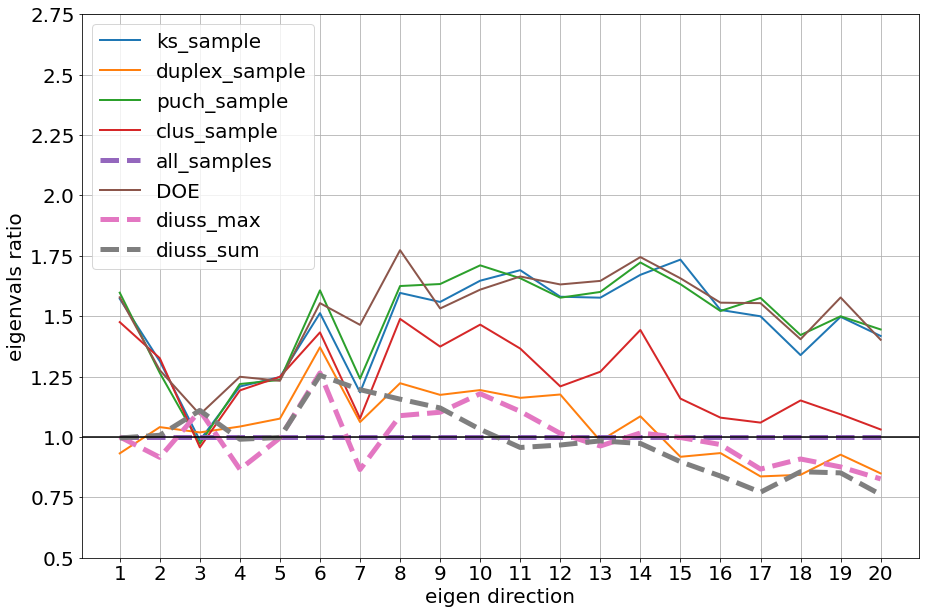

In [30]:
# --- visualize comparison svd
X_c = x_all - x_all.mean(axis=0)
X_c_t = np.ascontiguousarray(X_c.transpose())
cov_X = X_c_t.dot(X_c)/X_c.shape[0]
svd_cov_X = np.linalg.svd(cov_X)

# eigenvect comparison

print("determinant eigenvectors: \n")

for method_name in svd_methods.keys():
    
    svd_selected = svd_methods[method_name]
    eigen_vals_ratio = svd_selected[1][0:a]/svd_cov_X[1][0:a]
    eigen_vect_comparison = svd_selected[0][:,0:a].T.dot(svd_cov_X[0][:,0:a])
    eigen_vect_criterion = np.abs(np.linalg.det(eigen_vect_comparison))
    print(method_name,": ",np.round(eigen_vect_criterion,3))
    
    
# eigenval comparison

font_size = 20
yticks = np.arange(0.5,3, 0.25)
xticks = np.arange(1,a+1)


fig, ax = plt.subplots(figsize = (15,10))

for method_name in svd_methods.keys():
    
    svd_selected = svd_methods[method_name]
    eigen_vals_ratio = svd_selected[1][0:a]/svd_cov_X[1][0:a]
    if method_name =="diuss_max" or method_name =="diuss_sum" or method_name =="all_samples" :
        ax.plot(xticks,eigen_vals_ratio, Linewidth =5 , label = method_name, linestyle='dashed')
    else:
        ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)

        
    
ax.grid()
ax.axhline(y=1, c = "black")
ax.set_xlabel("eigen direction", fontsize = font_size)
ax.set_xticks(xticks)
ax.set_xticklabels(labels = xticks, fontsize = font_size)
ax.set_ylabel("eigenvals ratio", fontsize = font_size)
ax.set_yticks(yticks)
ax.set_yticklabels(labels = yticks, fontsize = font_size)
ax.legend(fontsize = font_size)
plt.show()

## Cross validation PLSR model 

In [31]:
total_lv = 20
n_splits_cv = 10
n_shuffles = 1

In [32]:
model_evaluation = {}

for method_name in selected_sets.keys():
    
    selected_cal_set = selected_sets[method_name]
    xcal_pls = x_all[selected_cal_set==1,:]
    ycal_pls= y_all[selected_cal_set==1,:]
    
    parameters = {'n_components': list(range(1,total_lv+1))}
    pls_scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}
    
    for nn in range(n_shuffles):

        pls_cv = KFold(n_splits=n_splits_cv, shuffle=True)
        my_pls = PLSRegression(scale=False)
        my_pls_cv = GridSearchCV(my_pls, parameters, cv = pls_cv, scoring = pls_scoring, refit = False)
        my_pls_cv.fit( xcal_pls,  ycal_pls)
        
    model_evaluation[method_name] = {"rmsecv":-1*my_pls_cv.cv_results_["mean_test_rmse"],
                                    "r2cv":my_pls_cv.cv_results_["mean_test_r2"],
                                    }    
    # Note check this -1

<ipython-input-29-0c0da9c2d2e0>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-29-0c0da9c2d2e0>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-29-0c0da9c2d2e0>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-29-0c0da9c2d2e0>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange

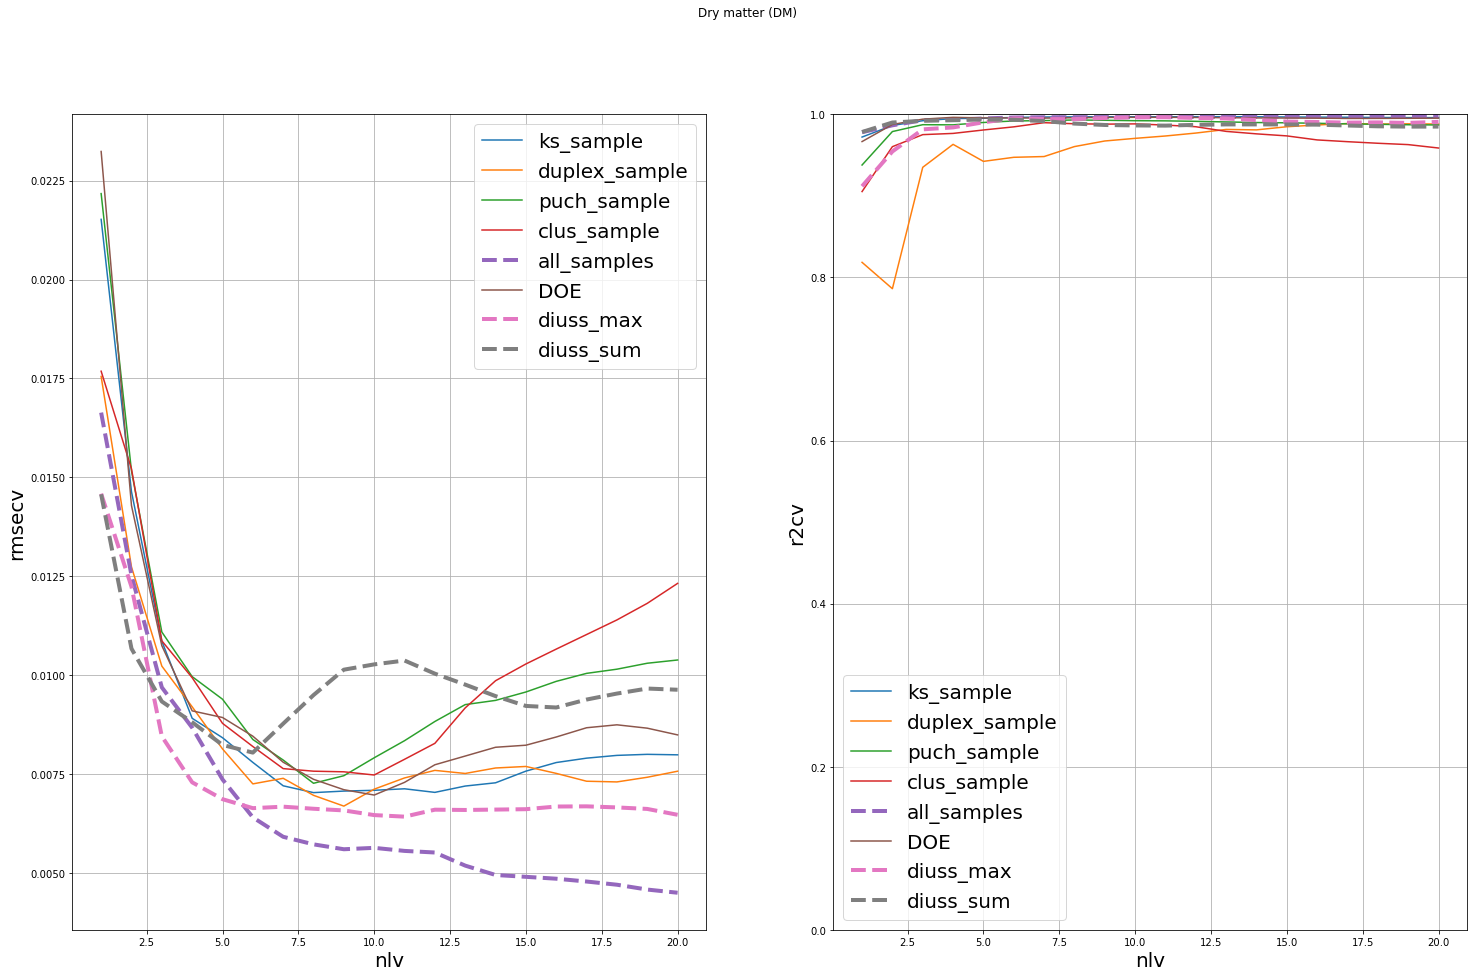

In [29]:
# Results Plots
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25,15))

for method_name in model_evaluation.keys():

    rmsecv = model_evaluation[method_name]["rmsecv"]
    r2cv = model_evaluation[method_name]["r2cv"]

    if method_name =='diuss_max' or method_name =='diuss_sum' or method_name =='all_samples'  :
        ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
        ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name, Linewidth =4,linestyle='dashed')        
    else:
        ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name)
        ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name)

ax[0].set_xlabel("nlv", fontsize = font_size)
ax[1].set_xlabel("nlv", fontsize = font_size)

ax[0].set_ylabel("rmsecv", fontsize = font_size)
ax[1].set_ylabel("r2cv", fontsize = font_size)

ax[1].set_ylim([0,1])  

ax[0].grid()
ax[1].grid()

ax[0].legend(fontsize = font_size)
ax[1].legend(fontsize = font_size)

y_name = "Dry matter (DM)"
fig.suptitle(y_name)

plt.show()

## PLSR

In [33]:
model_evaluation2 = {}

for method_name in selected_sets.keys():
    rmsep_all = np.zeros(total_lv)
    r2p_all = np.zeros(total_lv)
    
    selected_cal_set = selected_sets[method_name]
    xcal_pls = x_all[selected_cal_set==1,:]
    ycal_pls= y_all[selected_cal_set==1,:]
    xtest_pls = x_test
    ytest_pls= y_test
        
    for ii, chosen_lv in enumerate(range(1,total_lv+1)):
        
        my_pls = PLSRegression(n_components = chosen_lv,scale=False)
        my_pls.fit(xcal_pls, ycal_pls)
        x_mean = xcal_pls.mean(axis=0)
        y_mean = ycal_pls.mean(axis=0)
        
        # deliver model
        B = my_pls.coef_
        beta = y_mean - (x_mean.dot(B))

        ytest_pls_pred = xtest_pls.dot(B) + beta
        rmsep_all[ii] = np.sqrt(mean_squared_error(ytest_pls, ytest_pls_pred))
        r2p_all[ii] = r2_score(ytest_pls, ytest_pls_pred)
        
    model_evaluation2[method_name] = {"rmsep":rmsep_all,
                                    "r2p":r2p_all,
                                    }    

<ipython-input-36-ed059a0967f7>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-36-ed059a0967f7>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-36-ed059a0967f7>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-36-ed059a0967f7>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1,

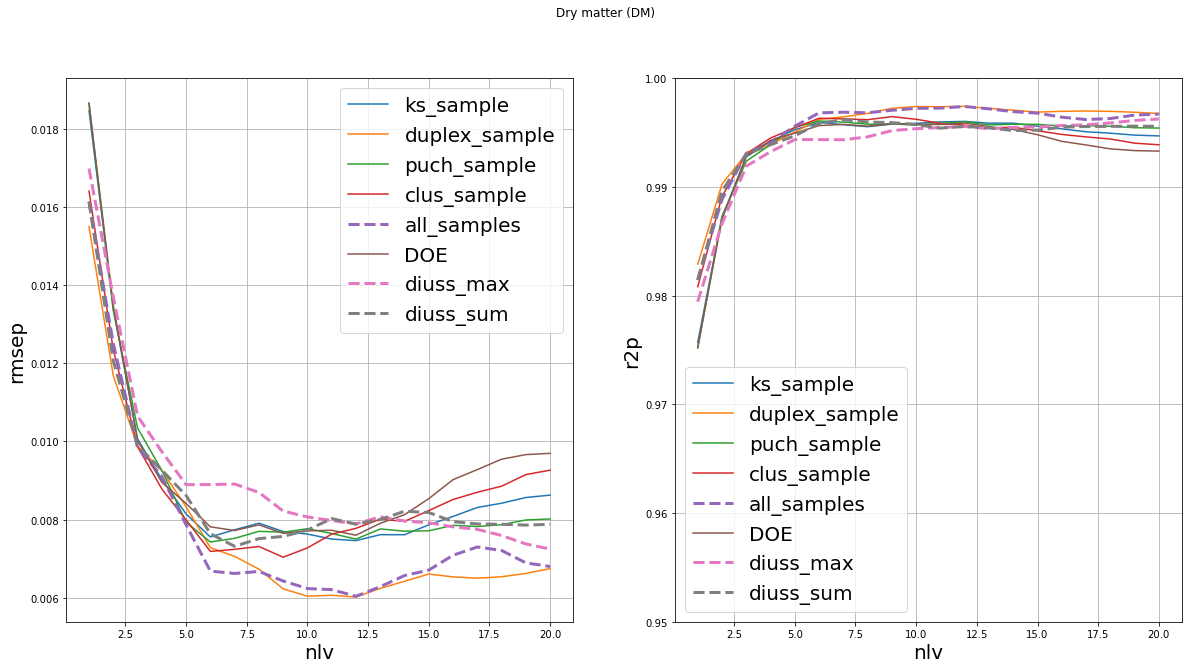

In [36]:
# Results Plots
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))

for method_name in model_evaluation2.keys():

    rmsep = model_evaluation2[method_name]["rmsep"]
    r2p = model_evaluation2[method_name]["r2p"]

    if method_name =='diuss_max' or method_name =='diuss_sum' or method_name =='all_samples'  :
        ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
        ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name, Linewidth =3,linestyle='dashed')        
    else:
        ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name)
        ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name)

ax[0].set_xlabel("nlv", fontsize = font_size)
ax[1].set_xlabel("nlv", fontsize = font_size)

ax[0].set_ylabel("rmsep", fontsize = font_size)
ax[1].set_ylabel("r2p", fontsize = font_size)

ax[1].set_ylim([0.95,1])  

ax[0].grid()
ax[1].grid()

ax[0].legend(fontsize = font_size)
ax[1].legend(fontsize = font_size)

y_name = "Dry matter (DM)"
fig.suptitle(y_name)

plt.show()

